# Classificação de poemas de heterónimos de Fernando Pessoa

## Experiência Interruptor com modelo LDA

## Passo 1: Importar as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import pickle 
import pyLDAvis

## Passo 2: Carregar os dados e filtrá-los

In [2]:
df = pd.read_csv('textos-pessoa.csv', index_col="autor")
df.head(10)

,título,texto,data,tipo
autor,,,,
Fernando Pessoa,ESTÉTICA - Um exemplo especialmente precioso é...,ESTÉTICA Um exemplo especialmente precioso é ...,1916?,prosa
Fernando Pessoa,"Há três espécies de Portugal, dentro do mesmo ...","Há três espécies de Portugal, dentro do mesmo ...",s.d.,prosa
Alberto Caeiro,"Verdade, mentira, certeza, incerteza…","Verdade, mentira, certeza, incerteza…\nAquele ...",12-4-1919,poesia
Ricardo Reis,OS DEUSES: DEFESA DELES,"OS DEUSES: DEFESA DELES\n\nTemos, como único d...",s.d.,prosa
Fernando Pessoa,[Carta a Ophélia Queiroz - 1 Mar. 1920],"Ophelinha:\n\nPara me mostrar o seu desprezo, ...",1-3-1920,prosa
Fernando Pessoa,Out of a great nebula of Night and Storm,Out of a great nebula of Night and Storm \nBor...,5-5-1915,prosa
Barão de Teive,"Viu-a desaparecer com mágoa, com rancor,","Viu-a desaparecer com mágoa, com rancor, com h...",s.d.,prosa
Alberto Caeiro,O amor é uma companhia,O amor é uma companhia.\nJá não sei andar só p...,10-7-1930,poesia
Fernando Pessoa,PRECISAMOS CRIAR PORTUGUESES,PRECISAMOS CRIAR PORTUGUESES\n\n\nO fundo da r...,s.d.,prosa


## Passo 3: Pré-processamento

Deixamos cair os heterónimos que não precisamos.

In [3]:
df.reset_index(inplace=True)

autores_principais = ['Fernando Pessoa', 'Bernardo Soares', 'Álvaro de Campos', 'Ricardo Reis', 'Alberto Caeiro']
dados = df[df['autor'].isin(autores_principais)].copy()
dados.autor.value_counts()

Fernando Pessoa     2814
Bernardo Soares      504
Álvaro de Campos     397
Ricardo Reis         307
Alberto Caeiro       127
Name: autor, dtype: int64

In [4]:
df

,autor,título,texto,data,tipo
0,Fernando Pessoa,ESTÉTICA - Um exemplo especialmente precioso é...,ESTÉTICA Um exemplo especialmente precioso é ...,1916?,prosa
1,Fernando Pessoa,"Há três espécies de Portugal, dentro do mesmo ...","Há três espécies de Portugal, dentro do mesmo ...",s.d.,prosa
2,Alberto Caeiro,"Verdade, mentira, certeza, incerteza…","Verdade, mentira, certeza, incerteza…\nAquele ...",12-4-1919,poesia
3,Ricardo Reis,OS DEUSES: DEFESA DELES,"OS DEUSES: DEFESA DELES\n\nTemos, como único d...",s.d.,prosa
4,Fernando Pessoa,[Carta a Ophélia Queiroz - 1 Mar. 1920],"Ophelinha:\n\nPara me mostrar o seu desprezo, ...",1-3-1920,prosa
...,...,...,...,...,...
4525,Eduardo Lança,ESTÁTUAS,ESTÁTUAS\n\nO bom Deus - em pequeno ouvi dizer...,24-5-1902,poesia
4526,Fernando Pessoa,«Vesti-me toda de novo,«Vesti-me toda de novo\n\n«Vesti-me toda de no...,s.d.,poesia
4527,Fernando Pessoa,ESTÉTICA - Um grande artista (literário) nota-...,ESTÉTICA\n\nUm grande artista (literário) nota...,1925?,prosa
4528,Bernardo Soares,"Por fácil que seja, todo o gesto representa a ...","Por fácil que seja, todo o gesto representa a ...",s.d.,prosa


Removemos pontuação, maiúsculas e quebras de linha.


In [5]:
def limpar_texto(serie_pandas):
    novo_texto = re.sub(r'[^\w\s]', ' ', serie_pandas).lower()
    novo_texto = re.sub(r'[\n]', ' ', novo_texto).lower()
    return novo_texto

dados.texto = dados.texto.apply(limpar_texto)
dados

,autor,título,texto,data,tipo
0,Fernando Pessoa,ESTÉTICA - Um exemplo especialmente precioso é...,estética um exemplo especialmente precioso é ...,1916?,prosa
1,Fernando Pessoa,"Há três espécies de Portugal, dentro do mesmo ...",há três espécies de portugal dentro do mesmo ...,s.d.,prosa
2,Alberto Caeiro,"Verdade, mentira, certeza, incerteza…",verdade mentira certeza incerteza aquele c...,12-4-1919,poesia
3,Ricardo Reis,OS DEUSES: DEFESA DELES,os deuses defesa deles temos como único dad...,s.d.,prosa
4,Fernando Pessoa,[Carta a Ophélia Queiroz - 1 Mar. 1920],ophelinha para me mostrar o seu desprezo ou...,1-3-1920,prosa
...,...,...,...,...,...
4523,Fernando Pessoa,"A nossa ânsia de verdade é grande,",a nossa ânsia de verdade é grande e por certo...,s.d.,prosa
4526,Fernando Pessoa,«Vesti-me toda de novo,vesti me toda de novo vesti me toda de novo...,s.d.,poesia
4527,Fernando Pessoa,ESTÉTICA - Um grande artista (literário) nota-...,estética um grande artista literário nota s...,1925?,prosa
4528,Bernardo Soares,"Por fácil que seja, todo o gesto representa a ...",por fácil que seja todo o gesto representa a ...,s.d.,prosa


Removemos texto em inglês.

In [6]:
dados = dados[dados.texto.apply(lambda x : detect(x))!='en']

In [7]:
dados

,autor,título,texto,data,tipo
0,Fernando Pessoa,ESTÉTICA - Um exemplo especialmente precioso é...,estética um exemplo especialmente precioso é ...,1916?,prosa
1,Fernando Pessoa,"Há três espécies de Portugal, dentro do mesmo ...",há três espécies de portugal dentro do mesmo ...,s.d.,prosa
2,Alberto Caeiro,"Verdade, mentira, certeza, incerteza…",verdade mentira certeza incerteza aquele c...,12-4-1919,poesia
3,Ricardo Reis,OS DEUSES: DEFESA DELES,os deuses defesa deles temos como único dad...,s.d.,prosa
4,Fernando Pessoa,[Carta a Ophélia Queiroz - 1 Mar. 1920],ophelinha para me mostrar o seu desprezo ou...,1-3-1920,prosa
...,...,...,...,...,...
4523,Fernando Pessoa,"A nossa ânsia de verdade é grande,",a nossa ânsia de verdade é grande e por certo...,s.d.,prosa
4526,Fernando Pessoa,«Vesti-me toda de novo,vesti me toda de novo vesti me toda de novo...,s.d.,poesia
4527,Fernando Pessoa,ESTÉTICA - Um grande artista (literário) nota-...,estética um grande artista literário nota s...,1925?,prosa
4528,Bernardo Soares,"Por fácil que seja, todo o gesto representa a ...",por fácil que seja todo o gesto representa a ...,s.d.,prosa


In [8]:
# remover stopwords

stopwords_pt = nltk.corpus.stopwords.words('portuguese')
stopwords_pt.append("porque")
dados['sem_stopwords'] = dados.apply(lambda x : ' '.join([palavra for palavra in x['texto'].split(' ') if palavra not in stopwords_pt]), axis = 1)


/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
#tokenização

nltk.download('punkt')

tokens = nltk.word_tokenize(dados['sem_stopwords'][2])
dados['tokens'] = dados['sem_stopwords'].apply(nltk.word_tokenize)


[nltk_data] Downloading package punkt to /home/rute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
# Stemming
nltk.download('rslp')
ps = nltk.stem.RSLPStemmer()

dados['raiz'] = dados.apply(lambda x : [ps.stem(palavra) for palavra in x['tokens']], axis = 1)



[nltk_data] Downloading package rslp to /home/rute/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
/home/rute/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Passo 4: Nuvens de palavras

In [11]:
wordcloud_df = dados

ric_reis = wordcloud_df[wordcloud_df["autor"] == "Ricardo Reis"]
alv_camp = wordcloud_df[wordcloud_df["autor"] == "Álvaro de Campos"]
alb_caer = wordcloud_df[wordcloud_df["autor"] == "Alberto Caeiro"]
fern_pes = wordcloud_df[wordcloud_df["autor"] == "Fernando Pessoa"]
bern_soar = wordcloud_df[wordcloud_df["autor"] == "Bernardo Soares"]

Ricardo Reis


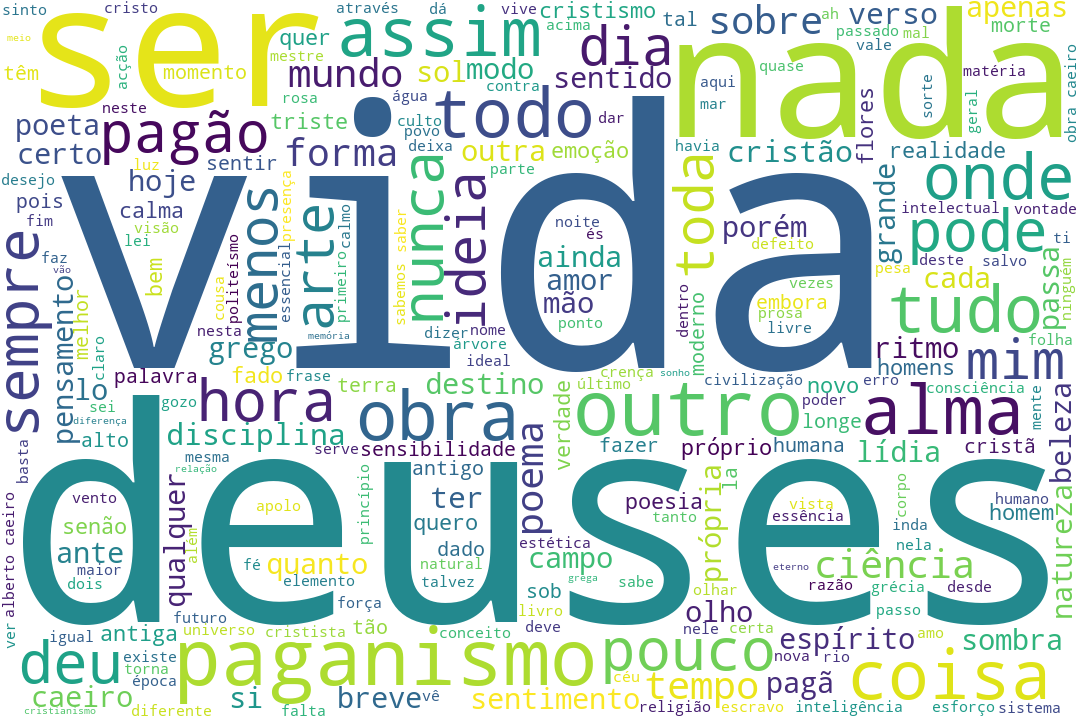

In [12]:
# Join the different processed titles together.
long_string_rr = ','.join(list(ric_reis['sem_stopwords'].values))
long_string_alv = ','.join(list(alv_camp['sem_stopwords'].values))
long_string_alb = ','.join(list(alb_caer['sem_stopwords'].values))
long_string_fp = ','.join(list(fern_pes['sem_stopwords'].values))
long_string_bs = ','.join(list(bern_soar['sem_stopwords'].values))

# Create a WordCloud object
#https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

wordcloud = WordCloud(background_color="white", width=1080, height=720, max_words=250)

# Generate a word cloud

# Visualize the word cloud
print("Ricardo Reis")
wordcloud.generate(long_string_rr)
wordcloud.to_file("nuvem-ricardo-reis.png")
wordcloud.to_image()

Álvaro de Campos


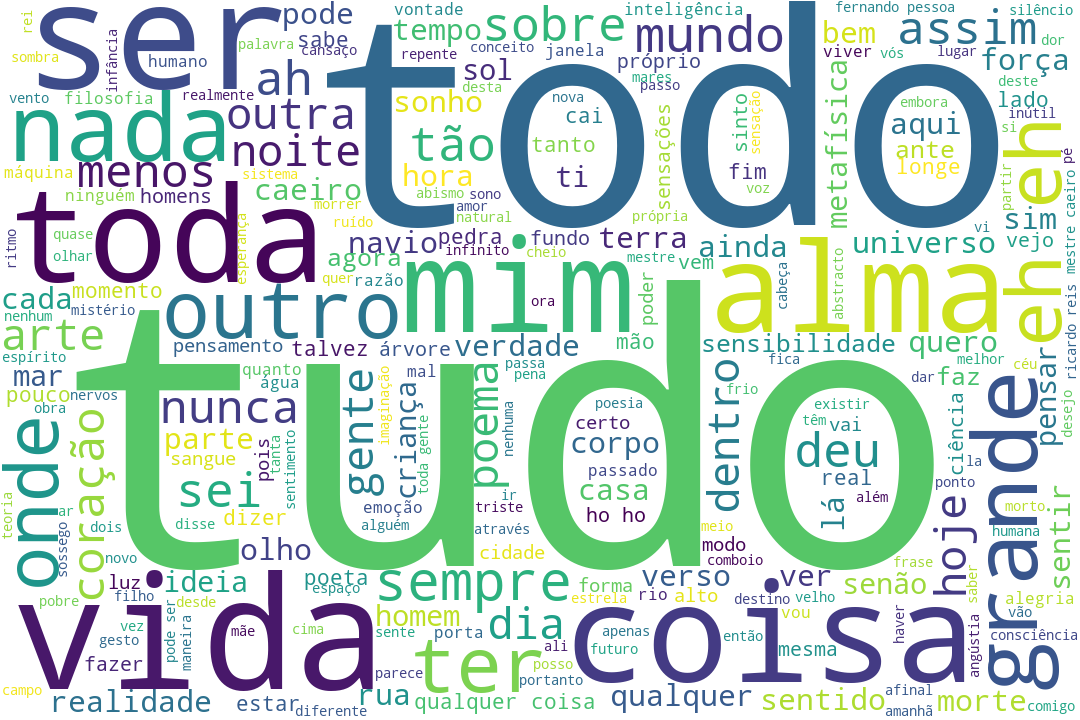

In [13]:
print("Álvaro de Campos")
wordcloud.generate(long_string_alv)
wordcloud.to_file("nuvem-alvaro-campos.png")
wordcloud.to_image()

Alberto Caeiro


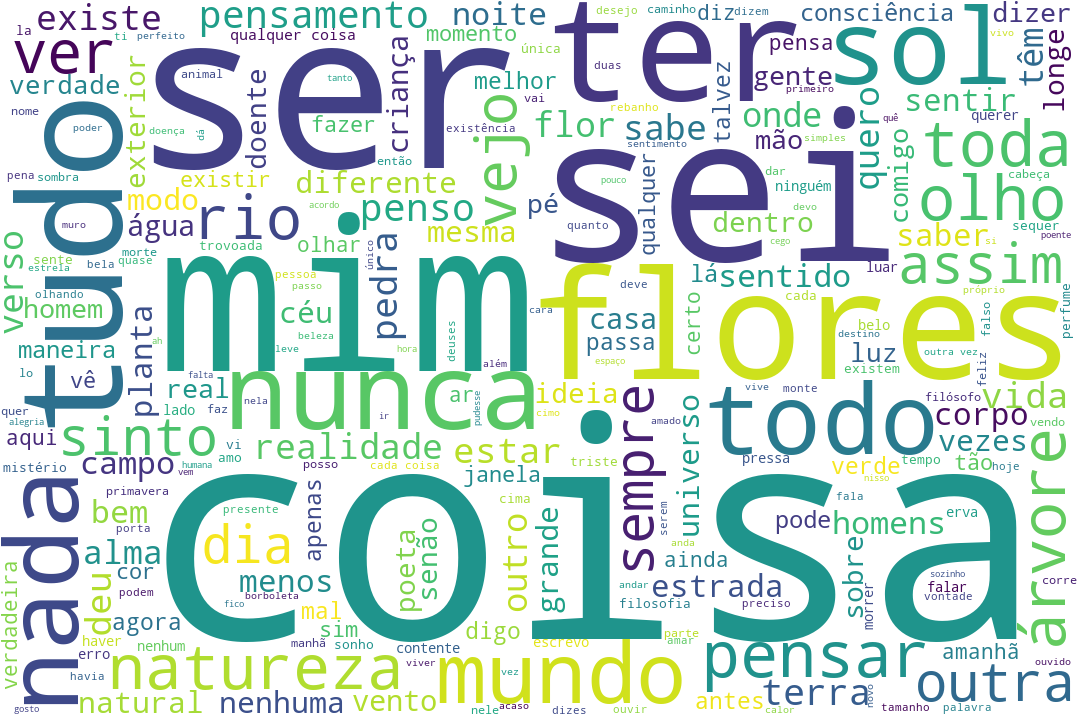

In [14]:
print("Alberto Caeiro")
wordcloud.generate(long_string_alb)
wordcloud.to_file("nuvem-alberto-caeiro.png")
wordcloud.to_image()

Fernando Pessoa


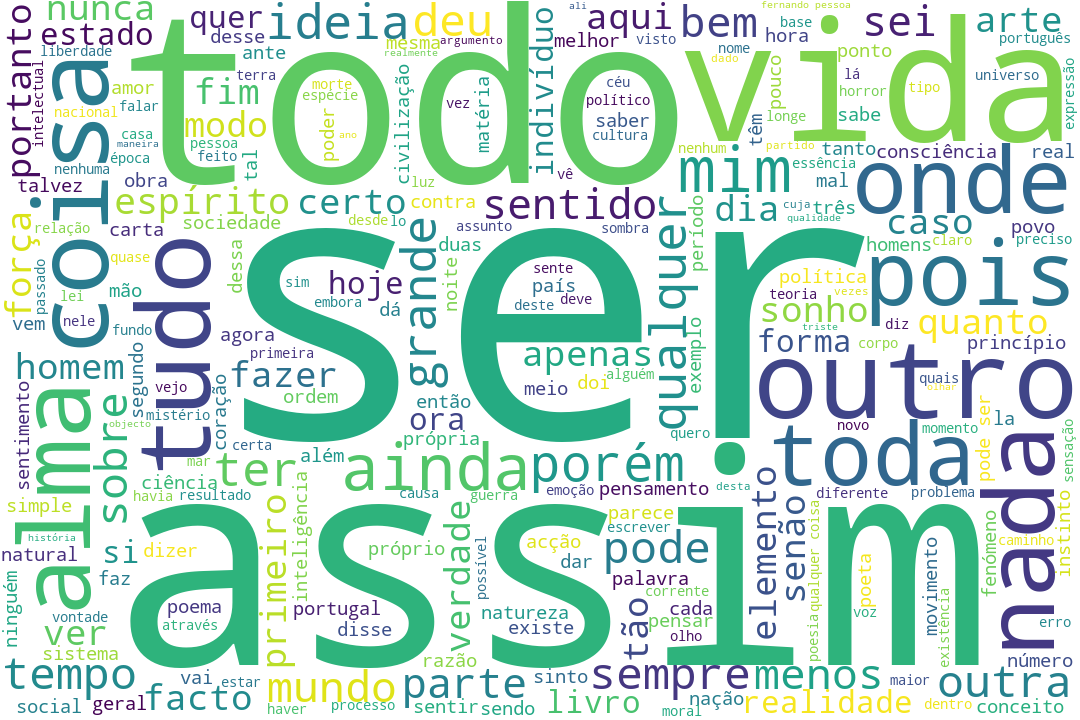

In [15]:
print("Fernando Pessoa")
wordcloud.generate(long_string_fp)
wordcloud.to_file("nuvem-fernando-pessoa.png")
wordcloud.to_image()

Bernardo Soares


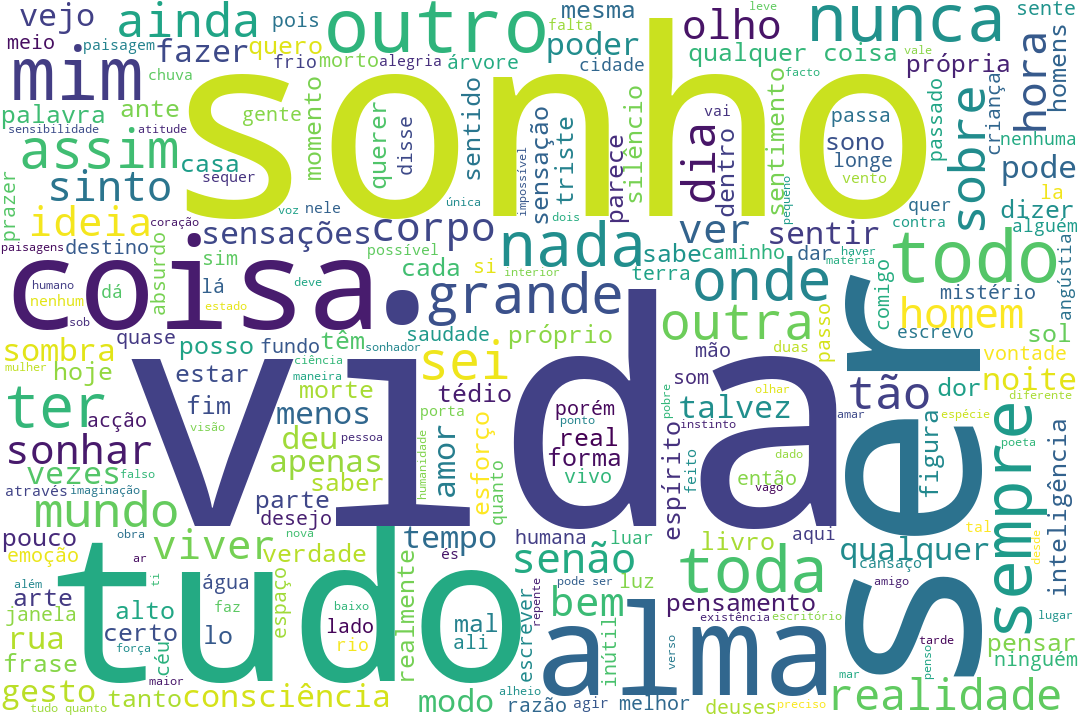

In [16]:
print("Bernardo Soares")
wordcloud.generate(long_string_bs)
wordcloud.to_file("nuvem-bernardo-soares.png")
wordcloud.to_image()

## Passo 5: Divisão treino/teste

In [17]:
y = dados['tokens']
X = dados.drop(['tokens'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


## Passo 6: Saco de palavras

In [18]:
processed_docs = y_train

id2word = gensim.corpora.Dictionary(processed_docs)

In [19]:
processed_docs

2029    [escrito, versos, verdade, escrito, principalm...
2303    [mar, manhã, suavemente, grande, avança, cheia...
3205    [levas, mão, cabelo, levas, mão, cabelo, gesto...
2125    [antínoo, adriano, fria, chuva, jaz, morto, jo...
1075    [1, preconceito, biológico, conceito, sociedad...
                              ...                        
3619    [império, alemão, eliminação, factores, estran...
3004    [sim, estado, novo, sim, estado, novo, povo, o...
3502    [paráfrase, concordância, algumas, profecias, ...
2140    [ix, guardador, rebanhos, rebanho, pensamentos...
238     [bebezinho, lindo, imaginas, graça, achei, hoj...
Name: tokens, Length: 2559, dtype: object

In [20]:
id2word.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
corpus = [id2word.doc2bow(doc) for doc in processed_docs]

In [21]:
#impressão para verificação

document_num = 20
bow_doc_x = corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Palavra {} (\"{}\") aparece {} vez(es).".format(bow_doc_x[i][0], 
                                                     id2word[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Palavra 56 ("dito") aparece 1 vez(es).
Palavra 154 ("conheço") aparece 1 vez(es).
Palavra 242 ("sonho") aparece 1 vez(es).
Palavra 341 ("compreender") aparece 2 vez(es).
Palavra 388 ("atenção") aparece 1 vez(es).
Palavra 488 ("amar") aparece 2 vez(es).
Palavra 489 ("companhia") aparece 1 vez(es).
Palavra 490 ("consegue") aparece 1 vez(es).
Palavra 491 ("definir") aparece 1 vez(es).
Palavra 492 ("especial") aparece 1 vez(es).
Palavra 493 ("esquecer") aparece 1 vez(es).
Palavra 494 ("falso") aparece 1 vez(es).
Palavra 495 ("l") aparece 1 vez(es).
Palavra 496 ("la") aparece 1 vez(es).
Palavra 497 ("odiar") aparece 1 vez(es).
Palavra 498 ("pensamentos") aparece 1 vez(es).
Palavra 499 ("pessoa") aparece 1 vez(es).
Palavra 500 ("presença") aparece 2 vez(es).
Palavra 501 ("solidão") aparece 1 vez(es).


## Passo 7: Aplicação do modelo LDA

In [22]:
lda_model =  gensim.models.LdaMulticore(corpus, 
                                   num_topics = 10, 
                                   id2word = id2word,                 
                                   passes = 20, alpha = 0.02,
                                   workers = 2)

In [23]:
'''
Para cada tópico, mostrar palavras-chave e o respectivo peso relativo.
'''
for idx, topic in lda_model.print_topics(-1):
    print("Tópico: {} \nPalavras: {}".format(idx, topic ))
    print("\n")



Tópico: 0 
Palavras: 0.013*"v" + 0.011*"pessoa" + 0.010*"livro" + 0.010*"fernando" + 0.010*"carta" + 0.008*"poemas" + 0.008*"escrever" + 0.007*"lisboa" + 0.007*"poema" + 0.007*"la"


Tópico: 1 
Palavras: 0.011*"social" + 0.008*"sociedade" + 0.007*"política" + 0.007*"país" + 0.007*"opinião" + 0.006*"povo" + 0.006*"contra" + 0.006*"portugal" + 0.006*"estado" + 0.006*"nação"


Tópico: 2 
Palavras: 0.023*"instinto" + 0.022*"arte" + 0.017*"inteligência" + 0.015*"meio" + 0.012*"ideal" + 0.010*"obra" + 0.009*"valor" + 0.009*"ideia" + 0.009*"força" + 0.008*"sensibilidade"


Tópico: 3 
Palavras: 0.014*"quero" + 0.010*"gente" + 0.008*"rua" + 0.007*"sinto" + 0.007*"sentir" + 0.007*"estar" + 0.007*"cabeça" + 0.006*"lá" + 0.006*"sol" + 0.006*"janela"


Tópico: 4 
Palavras: 0.010*"sonho" + 0.009*"noite" + 0.007*"amor" + 0.006*"céu" + 0.006*"deuses" + 0.006*"terra" + 0.005*"olhos" + 0.005*"coração" + 0.005*"sonhos" + 0.005*"sol"


Tópico: 5 
Palavras: 0.036*"2" + 0.033*"1" + 0.031*"3" + 0.018*"4" + 0

In [24]:
# verficação da marca de coerência
coherence_model_lda = CoherenceModel(model=lda_model, texts=dados['tokens'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('\nMarca de coerência: ', coherence_lda)


Marca de coerência:  0.5278259276474209


In [25]:
# Visualização de tópicos
pyLDAvis.enable_notebook()

LDAvis_train = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(LDAvis_train, 'lda.html') #exportar html
LDAvis_train

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.209462 -0.049810       1        1  19.633909
1     -0.118023 -0.028157       2        1  18.438969
9     -0.145674 -0.014868       3        1  10.501290
8     -0.146483 -0.039740       4        1   9.822514
0      0.017117  0.130159       5        1   9.734608
6     -0.055462 -0.068307       6        1   9.009091
3      0.195206 -0.031091       7        1   7.545712
7      0.202611 -0.058164       8        1   6.285756
2     -0.141673 -0.109904       9        1   5.461808
5     -0.017081  0.269883      10        1   3.566341, topic_info=          Term        Freq       Total Category  logprob  loglift
89           2  337.000000  337.000000  Default  30.0000  30.0000
85           1  342.000000  342.000000  Default  29.0000  29.0000
90           3  304.000000  304.000000  Default  28.0000  28.0000
364   instinto  348.000000  348.000000  Default  27.0000  27.0000
48        arte  409.000000  409.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
399       duas   52.851597  407.771454  Topic10  -4.7860   1.2904
360      ideia   45.756039  414.601501  Topic10  -4.9302   1.1296
417    palavra   35.874500  178.315582  Topic10  -5.1735   1.7301
1431   segundo   33.734745  291.327820  Topic10  -5.2350   1.1777
408      forma   32.764305  332.304230  Topic10  -5.2642   1.0169

[613 rows x 6 columns], token_table=      Topic      Freq Term
term                      
85        2  0.032150    1
85        3  0.049687    1
85        4  0.195824    1
85        5  0.058455    1
85        6  0.026305    1
...     ...       ...  ...
84        2  0.016906    ó
84        6  0.004226    ó
84        7  0.021132    ó
84        8  0.202867    ó
84       10  0.016906    ó

[2772 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 10, 9, 1, 7, 4, 8, 3, 6])